<a href="https://colab.research.google.com/github/hissain/mlworks/blob/main/codes/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Step 1. Import Libraries
- Step 2. Initial Setting
- Step 3. Define Generator
- Step 4. Define Discriminator
- Step 5. Define Loss Function
- Step 6. Initialize Generator and Discriminator
- Step 7. GPU Setting
- Step 8. Configure Data Loader
- Step 9. Define Optimizers
- Step 10. Training


In [ ]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [ ]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            # inplace=True : modify the input directly.
            # It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            # Asterisk('*') in front of block means
            # unpacking list of layers - leave only values(layers) in list

            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape)
        # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        # flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat)
        # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity


In [ ]:
adversarial_loss = torch.nn.BCELoss()

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
	torchvision.transforms.Normalize((0.5), (0.5))
])

dataset = torchvision.datasets.MNIST(
	root="./MNIST/train",
    train=True,
	transform=torchvision.transforms.ToTensor(),
	download=True
 )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5464142.01it/s] 


Extracting ./MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158515.98it/s]


Extracting ./MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1503740.04it/s]


Extracting ./MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7712764.68it/s]

Extracting ./MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw



In [ ]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [ ]:
temp_img.size() # before ToTensor() : (28,28,1), after : (1,28,28)

torch.Size([1, 28, 28])

In [ ]:
temp_img.max(), temp_img.min()

(tensor(1.), tensor(0.))

In [ ]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

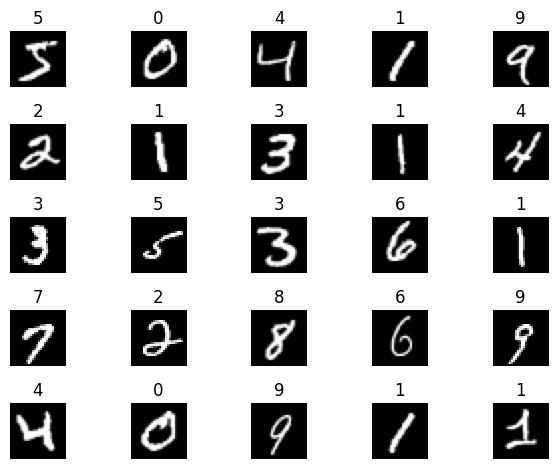

In [ ]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(
		 1,
		 len(dataset),
		 (25)
)

for idx in range(random_samples.shape[0]):
	plt.subplot(5, 5, idx + 1)
	plt.imshow(dataset[idx][0][0].numpy(), cmap='gray')
	plt.title(dataset[idx][1])
	plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

  0%|          | 0/938 [00:00<?, ?it/s]

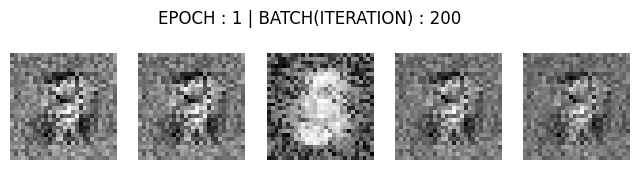

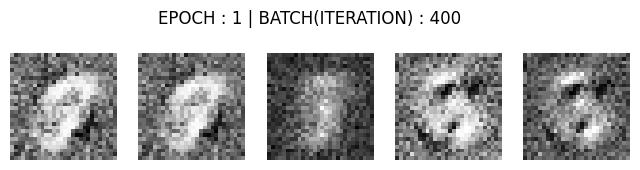

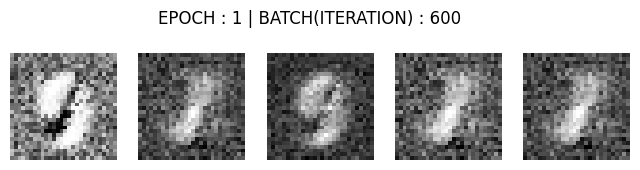

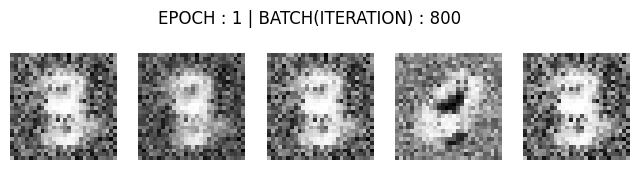

[Epoch: 1/10] [Batch: 938/938] [D loss: 0.601478] [G loss: 0.851696]


  0%|          | 0/938 [00:00<?, ?it/s]

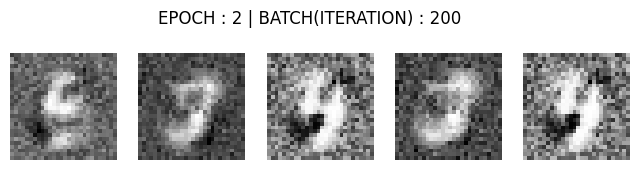

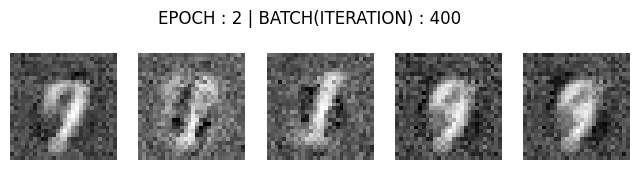

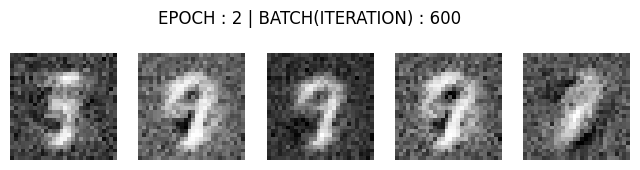

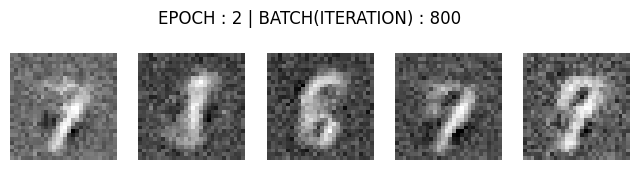

[Epoch: 2/10] [Batch: 938/938] [D loss: 0.372607] [G loss: 1.154681]


  0%|          | 0/938 [00:00<?, ?it/s]

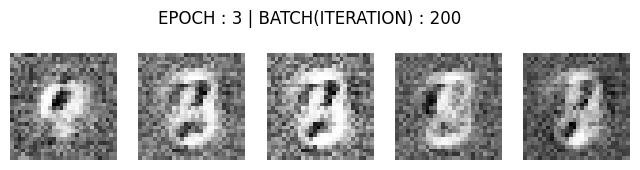

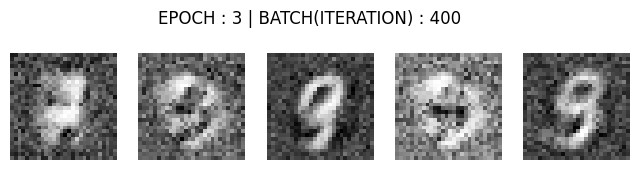

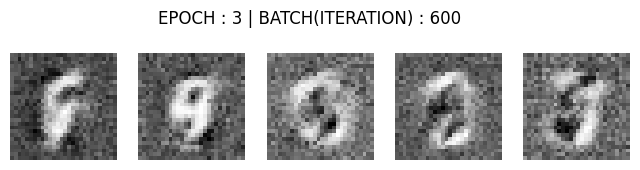

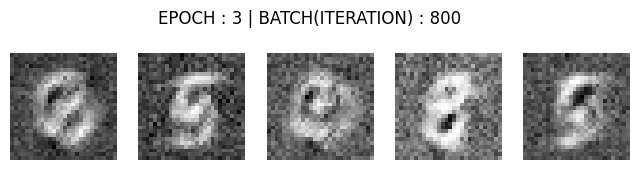

[Epoch: 3/10] [Batch: 938/938] [D loss: 0.457367] [G loss: 0.867314]


  0%|          | 0/938 [00:00<?, ?it/s]

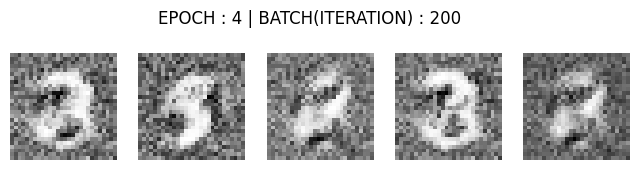

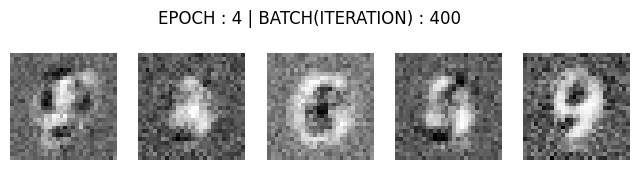

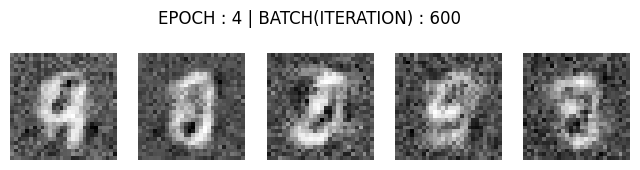

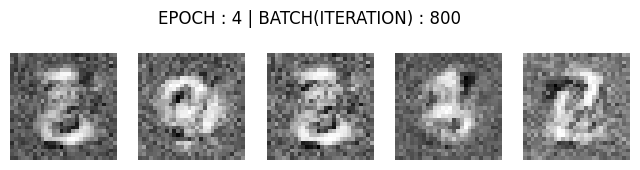

[Epoch: 4/10] [Batch: 938/938] [D loss: 0.368880] [G loss: 1.163330]


  0%|          | 0/938 [00:00<?, ?it/s]

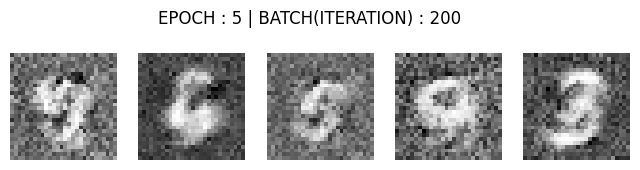

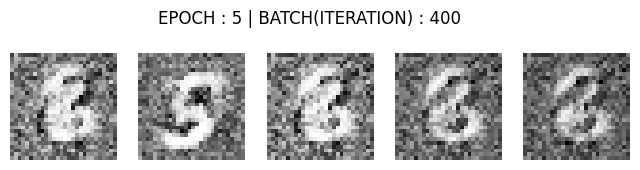

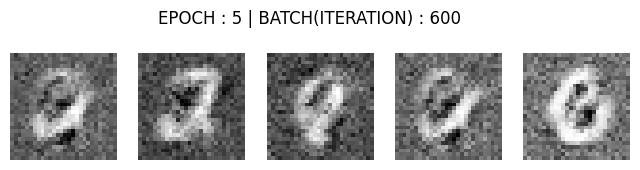

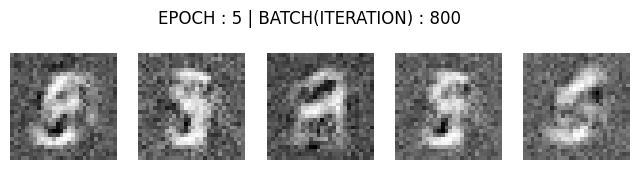

[Epoch: 5/10] [Batch: 938/938] [D loss: 0.361630] [G loss: 2.649033]


  0%|          | 0/938 [00:00<?, ?it/s]

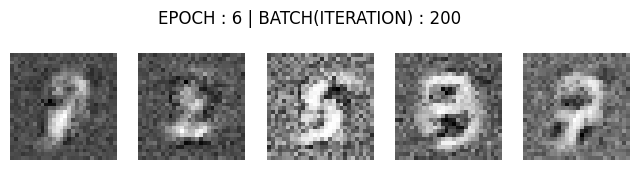

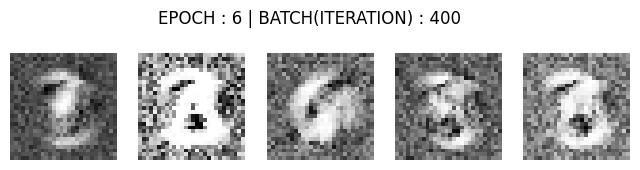

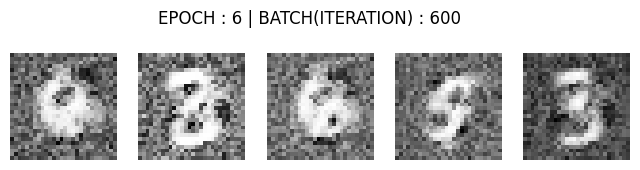

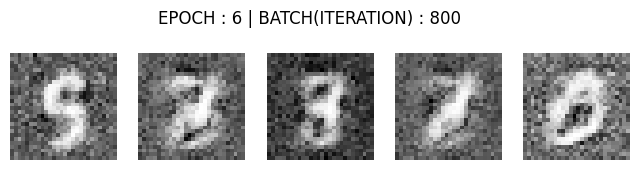

[Epoch: 6/10] [Batch: 938/938] [D loss: 0.270294] [G loss: 2.125412]


  0%|          | 0/938 [00:00<?, ?it/s]

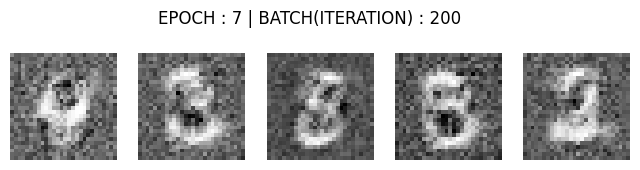

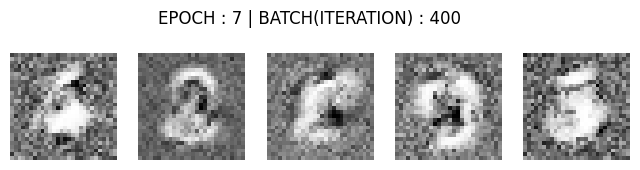

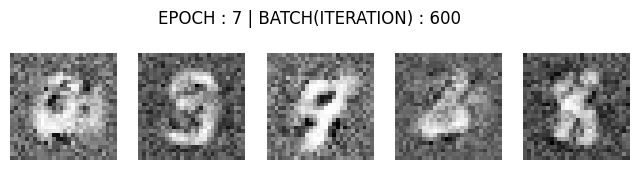

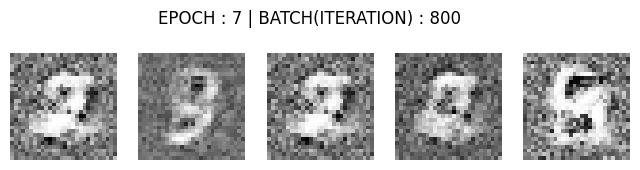

[Epoch: 7/10] [Batch: 938/938] [D loss: 0.519097] [G loss: 1.261175]


  0%|          | 0/938 [00:00<?, ?it/s]

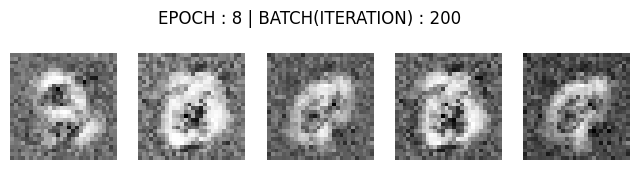

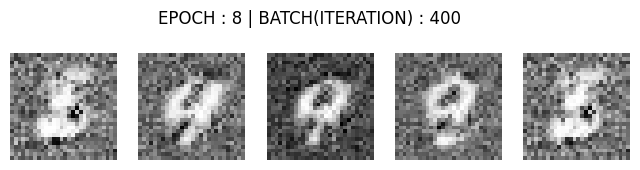

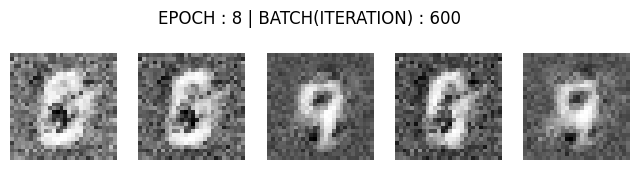

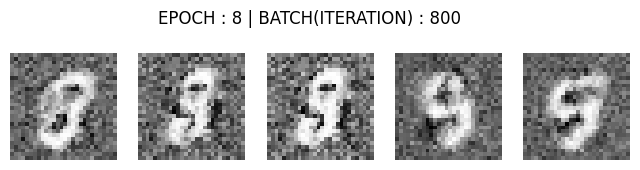

[Epoch: 8/10] [Batch: 938/938] [D loss: 0.233538] [G loss: 2.756370]


  0%|          | 0/938 [00:00<?, ?it/s]

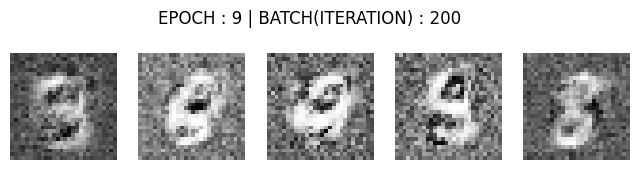

In [ ]:
n_epochs = 10 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)):
        # This code(enumerate) is dealt with once more in the *TEST_CODE below.
        # Used 'tqdm' for showing progress

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
        # requires_grad=False is default in tensor type.

        # Configure input
        real_imgs = imgs.type(Tensor)
        # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
        # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

        # ------------
        # Train Generator
        # ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

        # ------------
        # Train Discriminator
        # ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        # If didn't use detach() for gen_imgs, all weights of the generator
        #  will be calculated with backward().
        optimizer_D.step()



        # ------------
        # Real Time Visualization (While Training)
        # ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

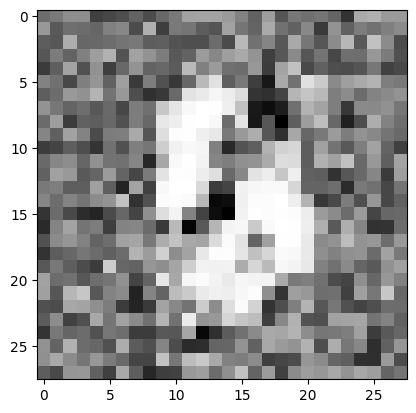

In [ ]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape

# generated images
sample_gen_imgs = generator(sample_z)
sample_gen_imgs.shape

plt.imshow(sample_gen_imgs[0, 0, :, :].detach().numpy(), cmap='gray')

In [ ]:
# discrimination result
sample_discrim_result = discriminator(sample_gen_imgs)
sample_discrim_result.shape

torch.Size([64, 1])

In [ ]:
sample_valid = Tensor(64,1).fill_(1.0)
sample_g_loss = adversarial_loss(sample_discrim_result, sample_valid)
sample_g_loss

tensor(1.7229, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
!pip install torchviz
import torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=e9ae012c10871751597b969ec6739a7a9331ac65dc42d8c3f5d08446de1ccd1f
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


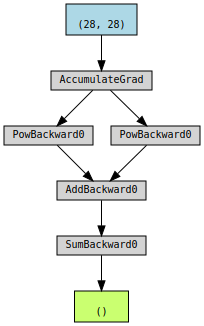

In [ ]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)

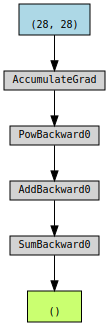

In [ ]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X.detach()**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)